In [54]:
# notebook imports

import math
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import matplotlib.image as mpimg
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [15]:
# make model call backs

save_path = 'model_experiments'

def create_model_checkpoint(model_name, save_path=save_path):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0, 
                                              save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=50,
                                                  restore_best_weights=True)

reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                      patience=500,
                                                      verbose=1)

In [3]:
# helper functions
from helper_functions import plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# get data

# face_data2 = '/content/drive/MyDrive/Colab Notebooks/Face_expression_recognition_project/face_expression/face_expression.zip'
# unzip_data(face_data2)
# /content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data


train_dir = '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data/train'
validation_dir = '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data/validation'

In [ ]:
import os
from PIL import Image
folder_path = validation_dir
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])

In [5]:
# How many images/classes are there?
walk_through_dir("/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data")

There are 2 directories and 0 images in '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data'.
There are 5 directories and 0 images in '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data/train'.
There are 0 directories and 39 images in '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data/train/cercospora_leaf_spot'.
There are 0 directories and 37 images in '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data/train/anthracnose'.
There are 0 directories and 42 images in '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data/train/phosphorus_deficiency'.
There are 0 directories and 42 images in '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data/train/rice_brown_leaf_spot'.
There are 0 directories and 50 images in '/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/data/train/sunflower_leaf_blight'.
There are 5 directories and 0 images in '/content

In [33]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)

data_dir = pathlib.Path(train_dir) 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['anthracnose' 'cercospora_leaf_spot' 'phosphorus_deficiency'
 'rice_brown_leaf_spot' 'sunflower_leaf_blight']


In [34]:
# set target and batch size of image
TARGET_SIZE = (224, 224)
BATCH_SIZE = 128

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE, 
                                               target_size=TARGET_SIZE,
                                               class_mode="categorical", 
                                               seed=42)

valid_data = validation_datagen.flow_from_directory(validation_dir,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=TARGET_SIZE,
                                                    class_mode="categorical",
                                                    seed=42)

Found 210 images belonging to 5 classes.
Found 58 images belonging to 5 classes.


# Model 0

In [ ]:
# creat model: Base model

num_classes = len(class_names)

# Create a CNN model
model_0 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, 
                           kernel_size=3, 
                           activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"), 
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation="softmax")
], name='model_0')

# Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                       

In [ ]:
%%time
# Fit the model
callbacks_list = [create_model_checkpoint(model_0.name), early_stopping, reduce_plateau]

history_0 = model_0.fit(train_data,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=callbacks_list)

Epoch 1/20
2/2 [==============================] - 76s 50s/step - loss: 1.6220 - accuracy: 0.2714 - val_loss: 1.5695 - val_accuracy: 0.2931 - lr: 0.0010
Epoch 2/20
2/2 [==============================] - 28s 17s/step - loss: 1.5115 - accuracy: 0.4571 - val_loss: 1.5442 - val_accuracy: 0.2759 - lr: 0.0010
Epoch 3/20
2/2 [==============================] - 27s 16s/step - loss: 1.4013 - accuracy: 0.4714 - val_loss: 1.4296 - val_accuracy: 0.4310 - lr: 0.0010
Epoch 4/20
2/2 [==============================] - 27s 15s/step - loss: 1.3230 - accuracy: 0.5429 - val_loss: 1.3474 - val_accuracy: 0.4310 - lr: 0.0010
Epoch 5/20
2/2 [==============================] - 27s 15s/step - loss: 1.1268 - accuracy: 0.6857 - val_loss: 1.2342 - val_accuracy: 0.4138 - lr: 0.0010
Epoch 6/20
2/2 [==============================] - 27s 15s/step - loss: 0.9812 - accuracy: 0.7238 - val_loss: 1.1769 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/20
2/2 [==============================] - 27s 15s/step - loss: 0.8529 - accuracy

In [ ]:
model_0.evaluate(valid_data)

1/1 [==============================] - 6s 6s/step - loss: 0.6885 - accuracy: 0.7069


[0.6885467767715454, 0.7068965435028076]

In [ ]:
saved_model = tf.keras.models.load_model('model_experiments/model_0/')
saved_model.evaluate(valid_data)

1/1 [==============================] - 7s 7s/step - loss: 0.6280 - accuracy: 0.8103


[0.6280130743980408, 0.8103448152542114]

In [ ]:
saved_model.save('/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/saved_models/model_0.h5')

In [ ]:
test_m = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/saved_models/model_0.h5')
test_m.evaluate(valid_data)

1/1 [==============================] - 6s 6s/step - loss: 0.6280 - accuracy: 0.8103


[0.6280130743980408, 0.8103448152542114]

In [ ]:
type(test_m)

keras.engine.sequential.Sequential

In [32]:
# make Prediction

# Create a function to import an image and resize it to be able to be used with our model
def plot_and_pred(model, filename, img_shape=224):
    img = tf.io.read_file(filename)

    img = tf.image.decode_image(img, channels=3)

    img = tf.image.resize(img, size = [img_shape, img_shape])

    img = img/255.
    
    img = tf.expand_dims(img, axis=0)
    pred = model.predict(img)
    prob = f'{math.ceil(pred.max()*100)}%'
    pred_class = class_names[int(np.argmax(pred))]
    
    plt.title(f'{pred_class.title()} {prob}')
#     plt.xlabel(cuisines[pred_class])
    plt.grid(False)
    plt.axis(False)
    plt.imshow(np.squeeze(img))
    
    return pred_class

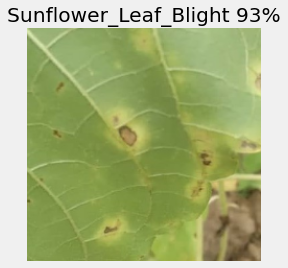

In [ ]:
# plt.figure(figsize=(5, 5))
p = plot_and_pred(test_m, 'test5.jpg')

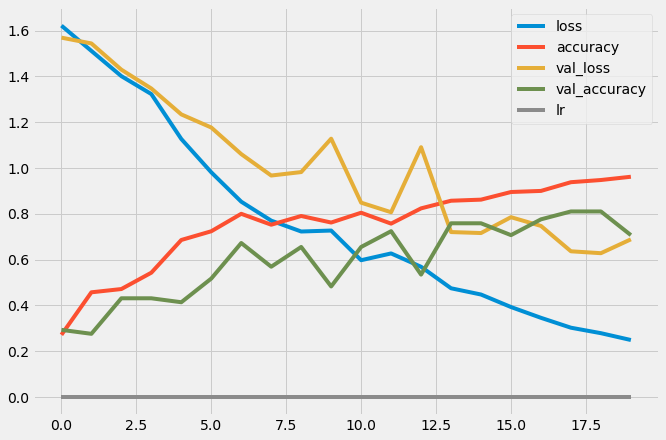

In [ ]:
pd.DataFrame(history_0.history).plot(figsize=(10, 7))

# Model 1
## same model as model 0, but with data augmentation

In [ ]:
# set target and batch size of image
TARGET_SIZE = (224, 224)
BATCH_SIZE = 128

# Set the seed
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=.2,
                                   zoom_range=.2,
                                   width_shift_range=.1,
                                   height_shift_range=.1,
                                   rotation_range=20,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale= 1./255)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE, 
                                               target_size=TARGET_SIZE,
                                               class_mode="categorical", 
                                               seed=42)

valid_data = validation_datagen.flow_from_directory(validation_dir,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=TARGET_SIZE,
                                                    class_mode="categorical",
                                                    seed=42)

Found 210 images belonging to 5 classes.
Found 58 images belonging to 5 classes.


In [ ]:
# create model: model 1

num_classes = len(class_names)

# Create a CNN model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, 
                           kernel_size=3, 
                           activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"), 
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation="softmax")
], name='model_1')

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                       

In [ ]:
%%time
# Fit the model
callbacks_list = [create_model_checkpoint(model_1.name), early_stopping, reduce_plateau]

history_1 = model_1.fit(train_data,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=callbacks_list)

Epoch 1/20
2/2 [==============================] - 35s 21s/step - loss: 1.6190 - accuracy: 0.2810 - val_loss: 1.5716 - val_accuracy: 0.2931 - lr: 0.0010
Epoch 2/20
2/2 [==============================] - 28s 16s/step - loss: 1.5332 - accuracy: 0.4190 - val_loss: 1.5520 - val_accuracy: 0.2586 - lr: 0.0010
Epoch 3/20
2/2 [==============================] - 30s 17s/step - loss: 1.4444 - accuracy: 0.4619 - val_loss: 1.4382 - val_accuracy: 0.3966 - lr: 0.0010
Epoch 4/20
2/2 [==============================] - 28s 15s/step - loss: 1.4176 - accuracy: 0.4524 - val_loss: 1.3525 - val_accuracy: 0.4655 - lr: 0.0010
Epoch 5/20
2/2 [==============================] - 28s 15s/step - loss: 1.2670 - accuracy: 0.5476 - val_loss: 1.2815 - val_accuracy: 0.4483 - lr: 0.0010
Epoch 6/20
2/2 [==============================] - 28s 15s/step - loss: 1.1809 - accuracy: 0.5857 - val_loss: 1.2799 - val_accuracy: 0.4483 - lr: 0.0010
Epoch 7/20
2/2 [==============================] - 28s 15s/step - loss: 1.1023 - accuracy

In [ ]:
model_1.evaluate(valid_data)

1/1 [==============================] - 12s 12s/step - loss: 0.6105 - accuracy: 0.7931


[0.6105399131774902, 0.7931034564971924]

In [ ]:
saved_model_1 = tf.keras.models.load_model('model_experiments/model_1/')
saved_model_1.evaluate(valid_data)

1/1 [==============================] - 6s 6s/step - loss: 0.6105 - accuracy: 0.7931


[0.6105399131774902, 0.7931034564971924]

In [ ]:
model_1.save('/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/saved_models/model_1.h5')

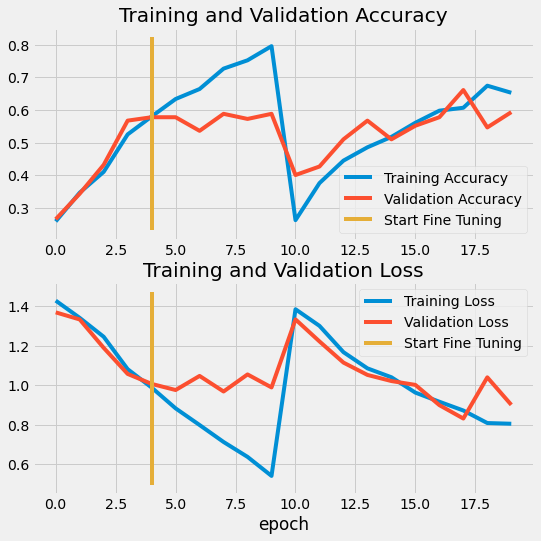

In [ ]:
compare_historys(history_0, history_1)

# Model 2
## same model as model 1, but for 30 epochs

In [35]:
# set target and batch size of image
TARGET_SIZE = (224, 224)
BATCH_SIZE = 128

# Set the seed
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=.2,
                                   zoom_range=.2,
                                   width_shift_range=.1,
                                   height_shift_range=.1,
                                   rotation_range=20,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale= 1./255)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE, 
                                               target_size=TARGET_SIZE,
                                               class_mode="categorical", 
                                               seed=42)

valid_data = validation_datagen.flow_from_directory(validation_dir,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=TARGET_SIZE,
                                                    class_mode="categorical",
                                                    seed=42)

Found 210 images belonging to 5 classes.
Found 58 images belonging to 5 classes.


In [36]:
# create model: model 2

num_classes = len(class_names)

# Create a CNN model
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, 
                           kernel_size=3, 
                           activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"), 
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation="softmax")
], name='model_2')

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [37]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_9 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_11 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                       

In [38]:
%%time
# Fit the model
callbacks_list = [create_model_checkpoint(model_2.name), early_stopping, reduce_plateau]

history_2 = model_2.fit(train_data,
                        epochs=30,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=callbacks_list)

Epoch 1/30
2/2 [==============================] - 36s 22s/step - loss: 1.6190 - accuracy: 0.2810 - val_loss: 1.5716 - val_accuracy: 0.2931 - lr: 0.0010
Epoch 2/30
2/2 [==============================] - 29s 20s/step - loss: 1.5298 - accuracy: 0.4143 - val_loss: 1.5415 - val_accuracy: 0.3103 - lr: 0.0010
Epoch 3/30
2/2 [==============================] - 28s 19s/step - loss: 1.4670 - accuracy: 0.3333 - val_loss: 1.4523 - val_accuracy: 0.4138 - lr: 0.0010
Epoch 4/30
2/2 [==============================] - 28s 15s/step - loss: 1.4411 - accuracy: 0.4429 - val_loss: 1.3653 - val_accuracy: 0.4655 - lr: 0.0010
Epoch 5/30
2/2 [==============================] - 28s 15s/step - loss: 1.3148 - accuracy: 0.4952 - val_loss: 1.3381 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 6/30
2/2 [==============================] - 27s 19s/step - loss: 1.2407 - accuracy: 0.5190 - val_loss: 1.3979 - val_accuracy: 0.3793 - lr: 0.0010
Epoch 7/30
2/2 [==============================] - 29s 19s/step - loss: 1.1872 - accuracy

In [39]:
model_2.evaluate(valid_data)

1/1 [==============================] - 6s 6s/step - loss: 0.4681 - accuracy: 0.8103


[0.4681417644023895, 0.8103448152542114]

In [49]:
saved_model_2 = tf.keras.models.load_model('model_experiments/model_2/')
saved_model_2.evaluate(valid_data)

1/1 [==============================] - 6s 6s/step - loss: 0.4681 - accuracy: 0.8103


[0.4681417644023895, 0.8103448152542114]

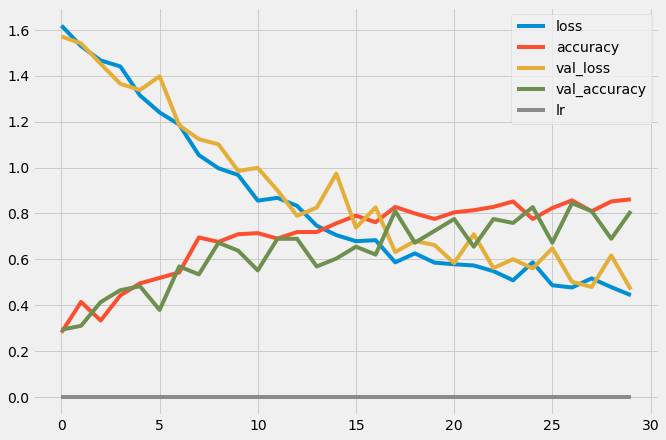

In [50]:
pd.DataFrame(history_2.history).plot(figsize=(10, 7))

In [51]:
model_2.save('/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/saved_models/model_2.h5')

# Model 0 with grascale images

In [12]:
# set target and batch size of image
TARGET_SIZE = (224, 224)
BATCH_SIZE = 128

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE, 
                                               target_size=TARGET_SIZE,
                                               color_mode="grayscale",
                                               class_mode="categorical", 
                                               seed=42)

valid_data = validation_datagen.flow_from_directory(validation_dir,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=TARGET_SIZE,
                                                    color_mode="grayscale",
                                                    class_mode="categorical",
                                                    seed=42)

Found 210 images belonging to 5 classes.
Found 58 images belonging to 5 classes.


In [18]:
# creat model: Base model

num_classes = len(class_names)

# Create a CNN model
model_0_gray = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, 
                           kernel_size=3, 
                           activation="relu",
                           input_shape=(224, 224, 1)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"), 
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation="softmax")
], name='model_0_gray')

# Compile the model
model_0_gray.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [19]:
%%time
# Fit the model
callbacks_list = [create_model_checkpoint(model_0_gray.name), early_stopping, reduce_plateau]

history_0_gray = model_0_gray.fit(train_data,
                                  epochs=30,
                                  steps_per_epoch=len(train_data),
                                  validation_data=valid_data,
                                  validation_steps=len(valid_data),
                                  callbacks=callbacks_list)

Epoch 1/30
2/2 [==============================] - 100s 79s/step - loss: 1.8055 - accuracy: 0.1905 - val_loss: 1.6910 - val_accuracy: 0.2069 - lr: 0.0010
Epoch 2/30
2/2 [==============================] - 29s 17s/step - loss: 1.6354 - accuracy: 0.2095 - val_loss: 1.6120 - val_accuracy: 0.1724 - lr: 0.0010
Epoch 3/30
2/2 [==============================] - 31s 22s/step - loss: 1.6012 - accuracy: 0.2000 - val_loss: 1.5885 - val_accuracy: 0.1724 - lr: 0.0010
Epoch 4/30
2/2 [==============================] - 29s 21s/step - loss: 1.5633 - accuracy: 0.2000 - val_loss: 1.5549 - val_accuracy: 0.1724 - lr: 0.0010
Epoch 5/30
2/2 [==============================] - 29s 22s/step - loss: 1.5233 - accuracy: 0.2000 - val_loss: 1.5443 - val_accuracy: 0.1724 - lr: 0.0010
Epoch 6/30
2/2 [==============================] - 29s 21s/step - loss: 1.4973 - accuracy: 0.2000 - val_loss: 1.5115 - val_accuracy: 0.2414 - lr: 0.0010
Epoch 7/30
2/2 [==============================] - 30s 22s/step - loss: 1.4587 - accurac

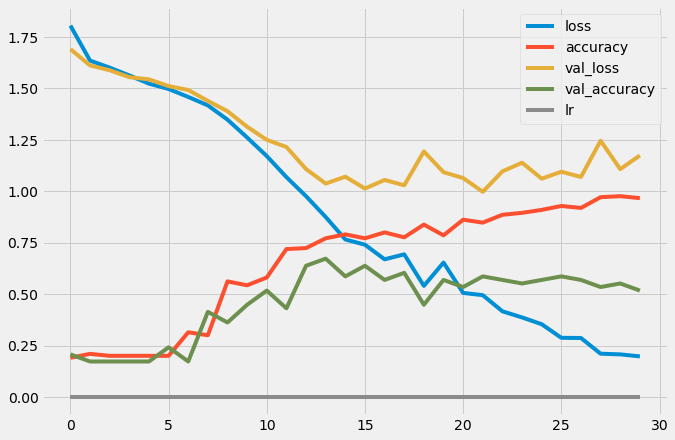

In [48]:
pd.DataFrame(history_0_gray.history).plot(figsize=(10, 7))

In [21]:
saved_model_0_gray = tf.keras.models.load_model('model_experiments/model_0_gray/')
saved_model_0_gray.evaluate(valid_data)

1/1 [==============================] - 7s 7s/step - loss: 0.9976 - accuracy: 0.5862


[0.997617244720459, 0.5862069129943848]

In [22]:
saved_model_0_gray.save('/content/drive/MyDrive/Colab Notebooks/plant_disease_identification/saved_models/model_0_gray.h5')

'rice_brown_leaf_spot'

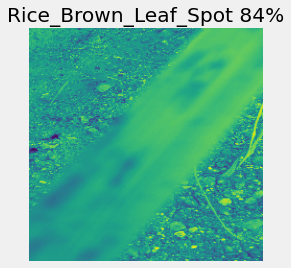

In [31]:
plot_and_pred(saved_model_0_gray, 'test4.jpg')

# Using Transfer Learning

In [60]:
# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), 
  preprocessing.RandomRotation(0.2), 
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2), 
  #preprocessing.Rescaling(1./255)  # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [61]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
transfer_model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [62]:
transfer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainab

In [63]:
# Compile
transfer_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
transfer_history = transfer_model.fit(train_data,
                                      epochs=5,
                                      steps_per_epoch=len(train_data),
                                      validation_data=valid_data,
                                      validation_steps=len(valid_data),
                                      callbacks=callbacks_list) 

Epoch 1/5
2/2 [==============================] - ETA: 0s - loss: 1.6253 - accuracy: 0.2381 

2/2 [==============================] - 43s 23s/step - loss: 1.6253 - accuracy: 0.2381 - val_loss: 1.6228 - val_accuracy: 0.2069 - lr: 0.0010
Epoch 2/5
2/2 [==============================] - 28s 19s/step - loss: 1.6171 - accuracy: 0.2381 - val_loss: 1.6176 - val_accuracy: 0.2069 - lr: 0.0010
Epoch 3/5
2/2 [==============================] - 28s 20s/step - loss: 1.6113 - accuracy: 0.2000 - val_loss: 1.6123 - val_accuracy: 0.2069 - lr: 0.0010
Epoch 4/5
2/2 [==============================] - 29s 20s/step - loss: 1.6250 - accuracy: 0.1524 - val_loss: 1.6094 - val_accuracy: 0.2069 - lr: 0.0010
Epoch 5/5
2/2 [==============================] - 28s 14s/step - loss: 1.6131 - accuracy: 0.1762 - val_loss: 1.6109 - val_accuracy: 0.2069 - lr: 0.0010


# Get model Metrics

In [76]:
# Make predictions with model
pred_probs_2 = model_2.predict(valid_data, verbose=1)

# Get the class predicitons of each label
pred_classes_2 = pred_probs_2.argmax(axis=1)




1/1 [==============================] - 6s 6s/step


In [83]:
model_2_accuracy = accuracy_score(valid_data.classes, pred_classes_2)
model_2_precision = precision_score(valid_data.classes, pred_classes_2, pos_label="positive", average='micro')
model_2_f1 = f1_score(valid_data.classes, pred_classes_2, pos_label="positive", average='micro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


In [88]:
pred_classes_2

array([4, 1, 3, 1, 2, 1, 3, 1, 4, 4, 3, 3, 4, 0, 1, 0, 4, 4, 3, 1, 1, 1,
       0, 1, 3, 0, 2, 0, 3, 2, 4, 1, 1, 4, 4, 0, 3, 0, 3, 1, 0, 2, 3, 1,
       2, 2, 4, 2, 2, 3, 4, 0, 0, 1, 3, 2, 1, 4])

In [89]:
valid_data.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)